# 1.0 Environment setup, module import

In [14]:
# add toolbox to src (THIS WILL NOT BE REQUIRED ONCE DEPLOYED)
import sys
from pathlib import Path
src_path = Path("../../src").resolve()

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from toolbox.steps.base_step import BaseStep, register_step
from toolbox.steps.custom import find_profiles_ALR as fpALR
import toolbox.utils.diagnostics as diag
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import tkinter as tk
import numpy as np
import re
import io
import matplotlib.pyplot as plt

# 2.0 Data import
Non-OG1 formatted ALR data is read in, formatted as a .log text file </br>
For compatability, looking to format into this input format: </br>
```
    Parameters
    ----------
    df : polars.DataFrame
        Input dataframe containing time and depth measurements
    gradient_thresholds : list
        Two-element list [positive_threshold, negative_threshold] defining the vertical velocity
        range (in meters/second) that is NOT considered part of a profile. typical values are around [0.02, -0.02]
    filter_win_sizes : list, default= ['20s', '10s']
        Window sizes for the compound filter applied to gradient calculations, in Polars duration format.
        index 0 controls the rolling median window size and index 1 controls the rolling mean window size.
    time_col : str, default='TIME'
        Name of the column containing timestamp data
    depth_col : str, default='DEPTH'
        Name of the column containing depth measurements
```

In [21]:
# Folder containing CTD files
sci_ctd_dir = Path("../../test_data")
sci_ctd_file_type = '*.log'

# Get a list of all .log files
sci_ctd_data_files = [str(file.resolve()) for file in sci_ctd_dir.glob(sci_ctd_file_type)]

# Folder containing science_navigation files
sci_nav_dir = Path("../../test_data")
sci_nav_file_type = '*.csv'

# Get a list of all .log files
sci_nav_data_files = [str(file.resolve()) for file in sci_nav_dir.glob(sci_nav_file_type)]


In [97]:

# Read in the CTD data
sci_ctd_file = sci_ctd_data_files[0]
sci_nav_file = sci_nav_data_files[1]

# Read in the nav data

with open(sci_ctd_file, "r") as f:
    lines = f.readlines()

# Identify start/end of each segment
segments = []
current_type = None
current_start = None

for i, line in enumerate(lines):
    if "4 Hz" in line:
        if current_type is not None:
            segments.append((current_type, current_start, i))
        current_type = "4hz"
        current_start = i + 1
    elif "1 Hz" in line:
        if current_type is not None:
            segments.append((current_type, current_start, i))
        current_type = "1hz"
        current_start = i + 1

if current_type is not None:
    segments.append((current_type, current_start, len(lines)))

parsed_segments = []

for seg_type, start, end in segments:
    raw = "".join(lines[start:end])

    if seg_type == "4hz":
        df = pl.read_csv(
            io.StringIO(raw),
            has_header=False,
            separator=",",
            new_columns=["Timestamp", "Pressure"],
            schema_overrides={
                "Timestamp": pl.Float64,
                "Pressure": pl.Float64,
            },
            null_values=["", "NaN", "S>"],
            ignore_errors=True
        )

    elif seg_type == "1hz":
        df = pl.read_csv(
            io.StringIO(raw),
            has_header=False,
            separator=",",
            new_columns=["Timestamp", "Conductivity", "Temperature", "Pressure", "Oxygen"],
            schema_overrides={
                "Timestamp": pl.Float64,
                "Conductivity": pl.Float64,
                "Temperature": pl.Float64,
                "Pressure": pl.Float64,
                "Oxygen": pl.Float64,
            },
            null_values=["", "NaN", "S>"],
            ignore_errors=True
        )

    parsed_segments.append(df)

# Combine all segments
all_data = pl.concat(parsed_segments, how="diagonal").sort("Timestamp")

# Read the nav data
sci_nav_data = pl.read_csv(
              sci_nav_file,
              schema_overrides={
             "timestamp": pl.Float64,
             "position_lat": pl.Float64,
             "position_lon": pl.Float64,
             "depth": pl.Float64,
             "roll": pl.Float64,
             "pitch": pl.Float64,
             "heading": pl.Float64,
             "altitude": pl.Float64}
)

# Merge two datasets
all_data = all_data.with_columns(pl.col("Timestamp").cast(pl.Float64))
sci_nav_data = sci_nav_data.rename({"timestamp": "Timestamp"}).with_columns(
    pl.col("Timestamp").cast(pl.Float64)
)

combined = all_data.join(
    sci_nav_data,
    on="Timestamp",
    how="full"   # union of both datasets
)

# Collapse Timestamp + Timestamp_right into a single column
if "Timestamp_right" in combined.columns:
    combined = combined.with_columns(
        pl.coalesce([pl.col("Timestamp"), pl.col("Timestamp_right")]).alias("Timestamp")
    ).drop("Timestamp_right")

# Sort chronologically
combined = combined.sort("Timestamp")

# Interpolate depth/pressure values over time gaps
combined = combined.with_columns(
    pl.col("Pressure").interpolate_by("Timestamp")
)


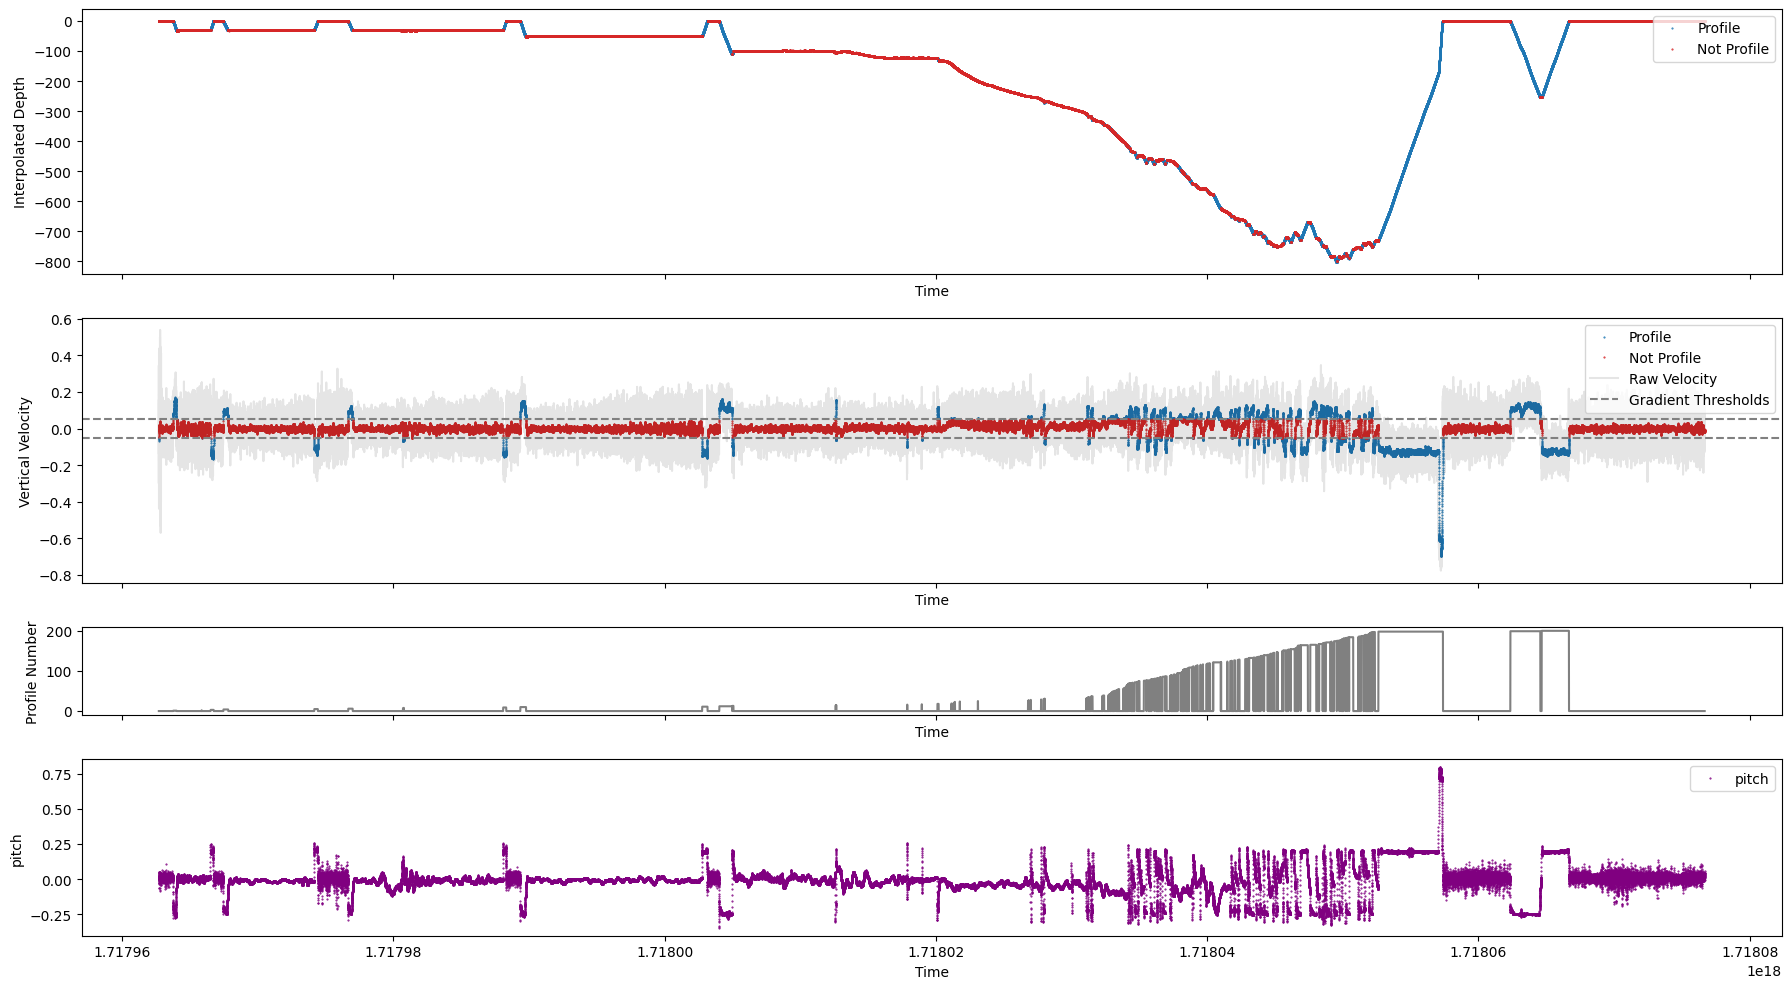

In [100]:
# --- Profiling analysis ---

import importlib
import toolbox.steps.custom.find_profiles_ALR as fpALR
importlib.reload(fpALR)

gradient_thresholds = [0.05, -0.05]

custom_column = 'pitch'

# Rename columns to what find_profiles expects
df = combined.rename({
    "Timestamp": "TIME",
    "Pressure": "DEPTH"   # treat pressure as depth for profiling
})

# Convert TIME (epoch seconds float) → Datetime[ns]
df = df.with_columns(
    (pl.col("TIME") * 1e9).cast(pl.Datetime("ns")).alias("TIME")
)

# Run profile detection with a custom column
profiles_df = fpALR.find_profiles(
    df,
    gradient_thresholds=gradient_thresholds,
    filter_win_sizes=["20s", "10s"],
    time_col="TIME",
    depth_col="DEPTH",
    cust_col=custom_column   # <<< custom column
)

# Split profiles vs not profiles
profiles = profiles_df.drop_nans().filter(pl.col("is_profile").cast(pl.Boolean))
not_profiles = profiles_df.drop_nans().filter(pl.col("is_profile").cast(pl.Boolean).not_())

# --- Plotting (now 4 panels, like script) ---
fig, axs = plt.subplots(4, 1, figsize=(18, 10), height_ratios=[3, 3, 1, 2], sharex=True)

axs[0].set(xlabel="Time", ylabel="Interpolated Depth")
axs[1].set(xlabel="Time", ylabel="Vertical Velocity")
axs[2].set(xlabel="Time", ylabel="Profile Number")
axs[3].set(xlabel="Time", ylabel=custom_column)   # <<< custom col

# Profile vs not profile (depth + velocity)
for data, col, label in zip([profiles, not_profiles], ["tab:blue", "tab:red"], ["Profile", "Not Profile"]):
    axs[0].plot(data["TIME"].to_numpy(), -data["INTERP_DEPTH"].to_numpy(),
                marker=".", markersize=1, ls="", c=col, label=label)
    axs[1].plot(data["TIME"].to_numpy(), data["smooth_grad"].to_numpy(),
                marker=".", markersize=1, ls="", c=col, label=label)

# Raw gradients + thresholds
axs[1].plot(profiles_df["TIME"].to_numpy(), profiles_df["grad"].to_numpy(),
            c="k", alpha=0.1, label="Raw Velocity")
for val, label in zip(gradient_thresholds, ["Gradient Thresholds", None]):
    axs[1].axhline(val, ls="--", color="gray", label=label)

# Profile numbers
axs[2].plot(profiles_df["TIME"].to_numpy(), profiles_df["profile_num"].to_numpy(), c="gray")

# Custom column (pitch)
if custom_column in profiles_df.columns:
    axs[3].plot(profiles_df["TIME"].to_numpy(),
                profiles_df[custom_column].to_numpy(),
                c="purple", marker=".", markersize=1, ls="", label=custom_column)
    axs[3].legend(loc="upper right")

for ax in axs[:2]:
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()